# Trading Strategies powered by Machine Learning - Logistic Regression

## Logistic Regression with scikit-learn - a Simple Introduction

In [54]:
import sys
sys.path.append('../../')

In [55]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [57]:
from backtesting import Strategy

## Getting the Data

In [58]:
XAUUSD = load_data()

In [59]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [60]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


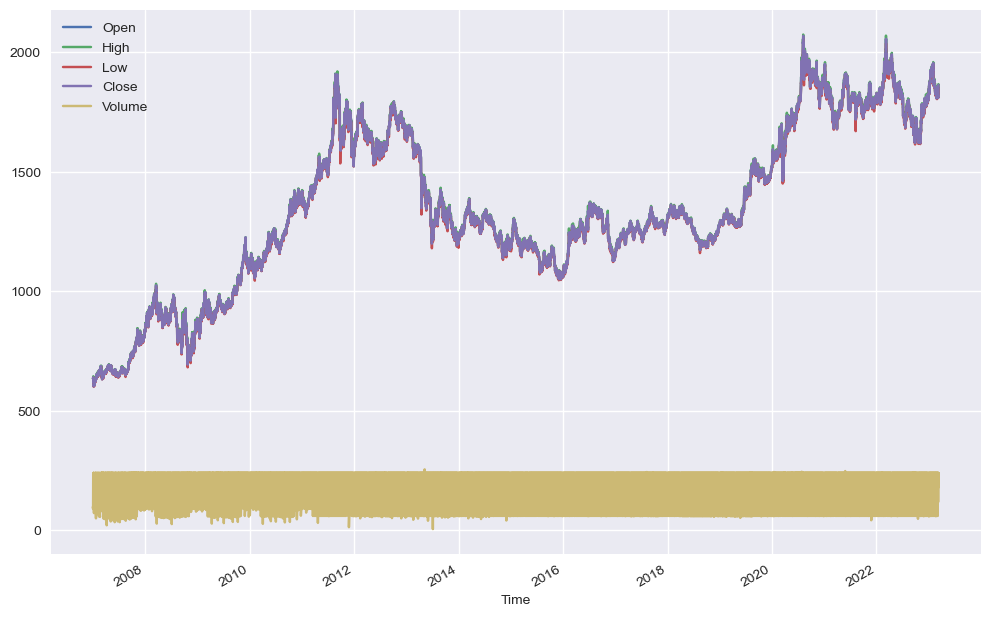

In [61]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [62]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [63]:
strategy = Logistic_Regression
account_size = 1000
folder_ML_Strategy = 'Logistic Regression'

In [64]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["return_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        data["direction"] = np.sign(data.return_signal)

        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
        lm.fit(data[cols], data['direction'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin= 1/100)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        
        self.Predict()
        result_test = self.Backtest(self.data_test)
        

        return result_train, result_test

## TF D1

In [65]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [66]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [67]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [68]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-30 00:00:00
Duration                   5105 days 00:00:00
Exposure Time [%]                   99.954097
Equity Final [$]                     2119.599
Equity Peak [$]                      2358.791
Return [%]                           111.9599
Buy & Hold Return [%]                211.0994
Return (Ann.) [%]                    4.440718
Volatility (Ann.) [%]               13.940673
Sharpe Ratio                         0.318544
Sortino Ratio                        0.463059
Calmar Ratio                         0.128677
Max. Drawdown [%]                  -34.510696
Avg. Drawdown [%]                   -2.588452
Max. Drawdown Duration     2748 days 00:00:00
Avg. Drawdown Duration       70 days 00:00:00
# Trades                                  533
Win Rate [%]                        58.161351
Best Trade [%]                      11.996011
Worst Trade [%]                    -16.120825
Avg. Trade [%]                    

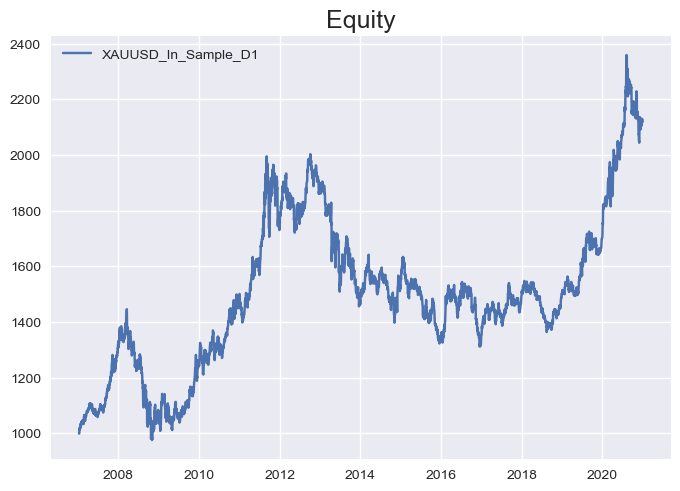

In [69]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [70]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                     1208.299
Equity Peak [$]                      1545.103
Return [%]                            20.8299
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                    4.959874
Volatility (Ann.) [%]               22.950181
Sharpe Ratio                         0.216115
Sortino Ratio                        0.316493
Calmar Ratio                         0.143214
Max. Drawdown [%]                  -34.632513
Avg. Drawdown [%]                   -4.727488
Max. Drawdown Duration      945 days 00:00:00
Avg. Drawdown Duration       66 days 00:00:00
# Trades                                   99
Win Rate [%]                        54.545455
Best Trade [%]                       7.799335
Worst Trade [%]                     -7.732588
Avg. Trade [%]                    

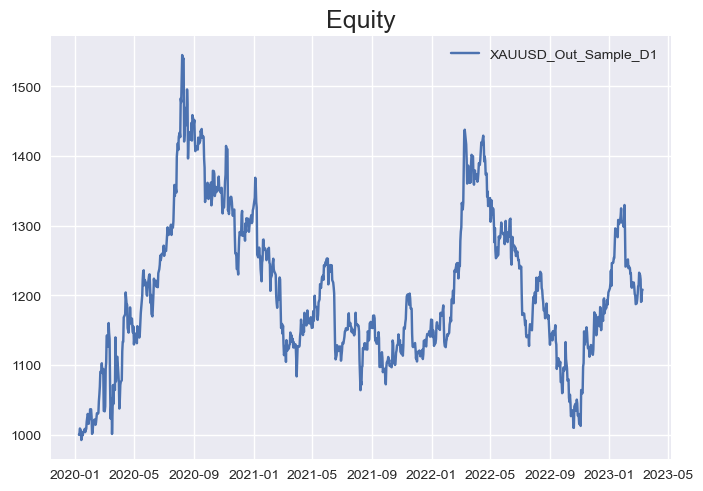

In [71]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [72]:
filename_train = f'result_{TF}_In_Sample.csv'

In [73]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [74]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [75]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [76]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [77]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [78]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [79]:
train

Start                     2007-01-02 00:00:00
End                       2020-12-31 16:00:00
Duration                   5112 days 16:00:00
Exposure Time [%]                   99.991098
Equity Final [$]                     3424.709
Equity Peak [$]                      3443.195
Return [%]                           242.4709
Buy & Hold Return [%]              197.611557
Return (Ann.) [%]                    7.382625
Volatility (Ann.) [%]                9.529419
Sharpe Ratio                         0.774719
Sortino Ratio                        1.238547
Calmar Ratio                         0.357774
Max. Drawdown [%]                  -20.634877
Avg. Drawdown [%]                   -0.878427
Max. Drawdown Duration     2781 days 16:00:00
Avg. Drawdown Duration       15 days 14:00:00
# Trades                                 6635
Win Rate [%]                        61.446873
Best Trade [%]                       6.728522
Worst Trade [%]                    -13.515261
Avg. Trade [%]                    

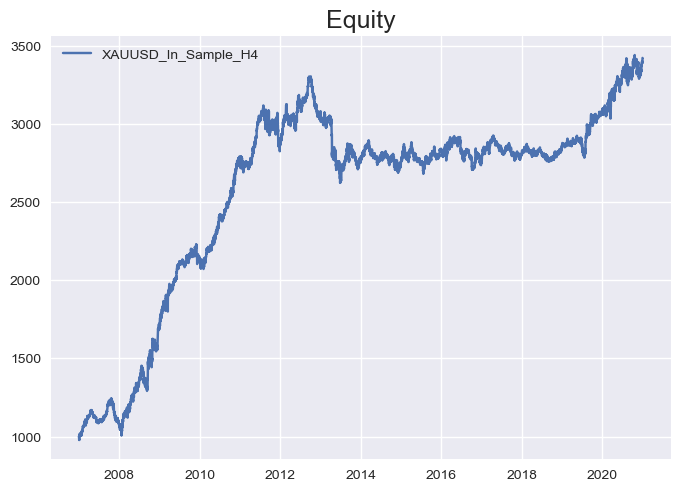

In [80]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [81]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                      901.069
Equity Peak [$]                      1342.824
Return [%]                            -9.8931
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                   -2.616839
Volatility (Ann.) [%]               24.755902
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -37.548331
Avg. Drawdown [%]                   -3.378449
Max. Drawdown Duration      870 days 04:00:00
Avg. Drawdown Duration       25 days 18:00:00
# Trades                                 1477
Win Rate [%]                        60.189573
Best Trade [%]                       3.305444
Worst Trade [%]                     -4.541249
Avg. Trade [%]                    

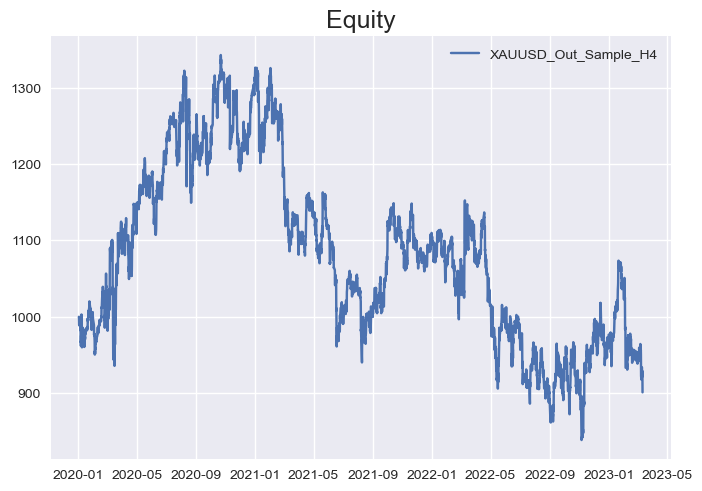

In [82]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [83]:
filename_train = f'result_{TF}_In_Sample.csv'

In [84]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [85]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [86]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [87]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [88]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [89]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [90]:
train

Start                     2007-01-01 06:00:00
End                       2020-12-31 20:00:00
Duration                   5113 days 14:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                      3876.78
Equity Peak [$]                      3876.797
Return [%]                            287.678
Buy & Hold Return [%]              198.974336
Return (Ann.) [%]                    8.135044
Volatility (Ann.) [%]               10.891082
Sharpe Ratio                         0.746945
Sortino Ratio                         1.14602
Calmar Ratio                         0.279606
Max. Drawdown [%]                  -29.094637
Avg. Drawdown [%]                   -0.467087
Max. Drawdown Duration     2584 days 08:00:00
Avg. Drawdown Duration        6 days 04:00:00
# Trades                                29826
Win Rate [%]                        66.304566
Best Trade [%]                       3.447623
Worst Trade [%]                     -8.309427
Avg. Trade [%]                    

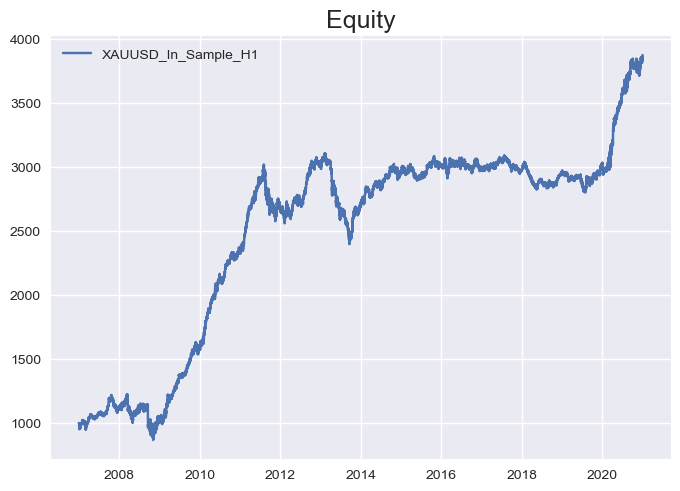

In [91]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [92]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                     2129.121
Equity Peak [$]                      2386.839
Return [%]                           112.9121
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   21.064875
Volatility (Ann.) [%]               19.252229
Sharpe Ratio                         1.094153
Sortino Ratio                        2.034803
Calmar Ratio                         1.164638
Max. Drawdown [%]                   -18.08706
Avg. Drawdown [%]                    -0.91693
Max. Drawdown Duration      451 days 07:00:00
Avg. Drawdown Duration        4 days 04:00:00
# Trades                                 6568
Win Rate [%]                        65.255786
Best Trade [%]                       3.292779
Worst Trade [%]                     -4.993373
Avg. Trade [%]                    

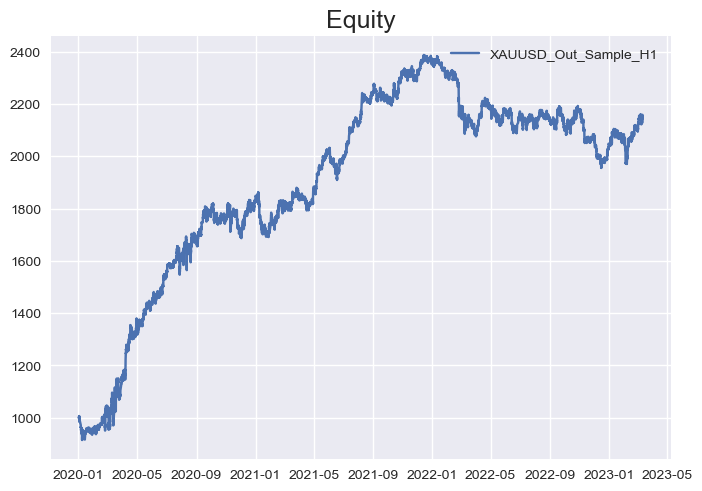

In [93]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [94]:
filename_train = f'result_{TF}_In_Sample.csv'

In [95]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [96]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [97]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [98]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [99]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [100]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [101]:
train

Start                     2007-01-01 03:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 18:00:00
Exposure Time [%]                   99.998819
Equity Final [$]                     5017.026
Equity Peak [$]                      5024.582
Return [%]                           401.7026
Buy & Hold Return [%]              198.691869
Return (Ann.) [%]                    9.740102
Volatility (Ann.) [%]                8.775652
Sharpe Ratio                         1.109901
Sortino Ratio                        1.763108
Calmar Ratio                         0.600888
Max. Drawdown [%]                  -16.209518
Avg. Drawdown [%]                   -0.298011
Max. Drawdown Duration      571 days 08:30:00
Avg. Drawdown Duration        2 days 22:16:00
# Trades                                59632
Win Rate [%]                        66.642071
Best Trade [%]                       3.226737
Worst Trade [%]                     -9.578469
Avg. Trade [%]                    

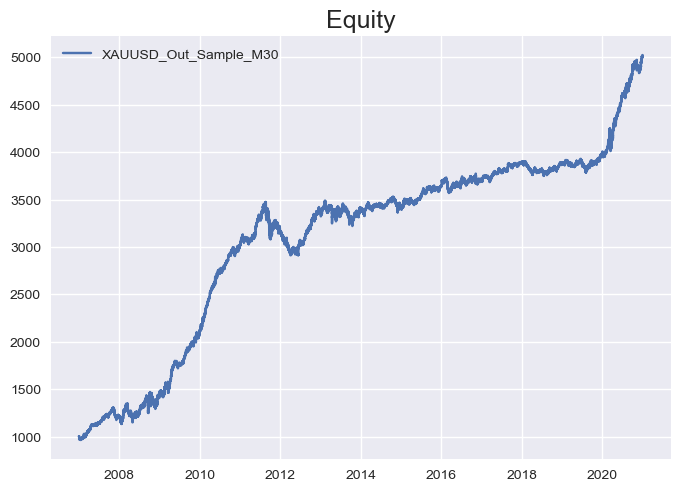

In [102]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [103]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     2962.207
Equity Peak [$]                      2969.404
Return [%]                           196.2207
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   31.658668
Volatility (Ann.) [%]               19.032245
Sharpe Ratio                         1.663423
Sortino Ratio                        3.492073
Calmar Ratio                         1.653629
Max. Drawdown [%]                  -19.144959
Avg. Drawdown [%]                   -0.517574
Max. Drawdown Duration      156 days 11:30:00
Avg. Drawdown Duration        2 days 00:02:00
# Trades                                13253
Win Rate [%]                        66.588697
Best Trade [%]                       1.917718
Worst Trade [%]                     -4.836667
Avg. Trade [%]                    

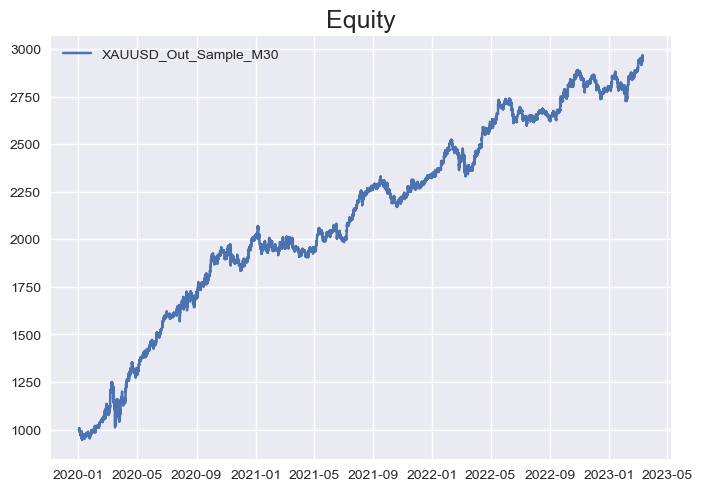

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [105]:
filename_train = f'result_{TF}_In_Sample.csv'

In [106]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [107]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [108]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [109]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [110]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [111]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [112]:
train

Start                     2014-09-23 14:30:00
End                       2020-12-31 21:30:00
Duration                   2291 days 07:00:00
Exposure Time [%]                   99.998651
Equity Final [$]                     3142.597
Equity Peak [$]                      3151.343
Return [%]                           214.2597
Buy & Hold Return [%]               55.396129
Return (Ann.) [%]                   15.878159
Volatility (Ann.) [%]               12.860439
Sharpe Ratio                         1.234651
Sortino Ratio                        2.135239
Calmar Ratio                         0.922508
Max. Drawdown [%]                  -17.211948
Avg. Drawdown [%]                    -0.33962
Max. Drawdown Duration      375 days 21:15:00
Avg. Drawdown Duration        2 days 01:16:00
# Trades                                52007
Win Rate [%]                        68.048532
Best Trade [%]                       2.433492
Worst Trade [%]                     -5.118639
Avg. Trade [%]                    

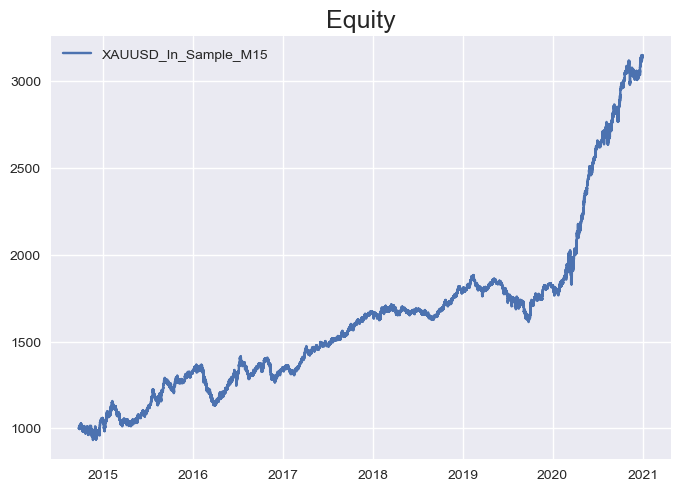

In [113]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [114]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     3289.103
Equity Peak [$]                      3315.586
Return [%]                           228.9103
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                   35.494132
Volatility (Ann.) [%]               18.142029
Sharpe Ratio                         1.956459
Sortino Ratio                        4.374807
Calmar Ratio                          2.16324
Max. Drawdown [%]                  -16.407859
Avg. Drawdown [%]                   -0.366884
Max. Drawdown Duration      149 days 01:00:00
Avg. Drawdown Duration        1 days 06:33:00
# Trades                                26296
Win Rate [%]                        68.253727
Best Trade [%]                       2.054545
Worst Trade [%]                     -5.118639
Avg. Trade [%]                    

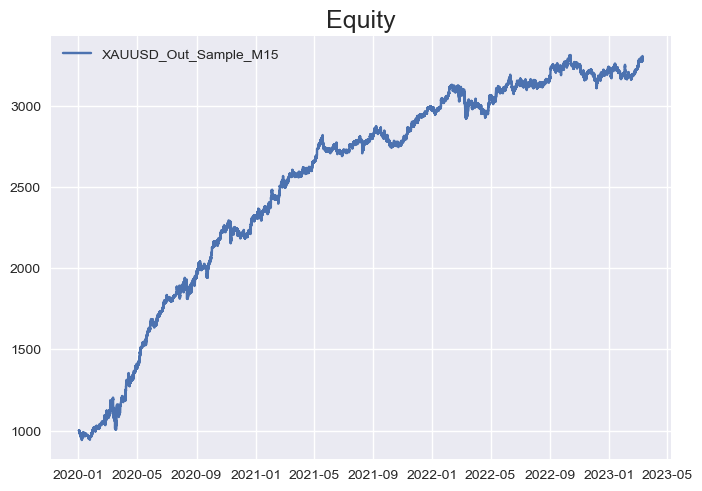

In [115]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [116]:
filename_train = f'result_{TF}_In_Sample.csv'

In [117]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [118]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [119]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [120]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [121]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [122]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [123]:
train

Start                     2020-05-15 11:40:00
End                       2023-03-10 17:50:00
Duration                   1029 days 06:10:00
Exposure Time [%]                      99.999
Equity Final [$]                     5326.095
Equity Peak [$]                      5361.285
Return [%]                           432.6095
Buy & Hold Return [%]                7.622745
Return (Ann.) [%]                   61.954847
Volatility (Ann.) [%]               14.914999
Sharpe Ratio                         4.153862
Sortino Ratio                       15.238094
Calmar Ratio                         9.065894
Max. Drawdown [%]                   -6.833837
Avg. Drawdown [%]                   -0.133497
Max. Drawdown Duration       91 days 04:30:00
Avg. Drawdown Duration        0 days 07:38:00
# Trades                                82796
Win Rate [%]                        64.808686
Best Trade [%]                          1.128
Worst Trade [%]                     -3.170082
Avg. Trade [%]                    

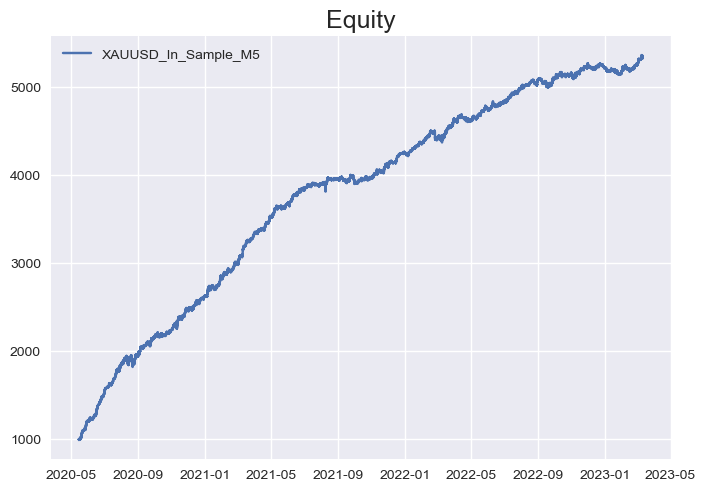

In [124]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [125]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     1108.525
Equity Peak [$]                      1144.862
Return [%]                            10.8525
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                   56.399471
Volatility (Ann.) [%]               31.419872
Sharpe Ratio                         1.795025
Sortino Ratio                        4.779605
Calmar Ratio                         6.949303
Max. Drawdown [%]                   -8.115846
Avg. Drawdown [%]                   -0.352457
Max. Drawdown Duration       30 days 04:15:00
Avg. Drawdown Duration        0 days 12:04:00
# Trades                                 5481
Win Rate [%]                        64.696223
Best Trade [%]                        0.46321
Worst Trade [%]                     -1.703677
Avg. Trade [%]                    

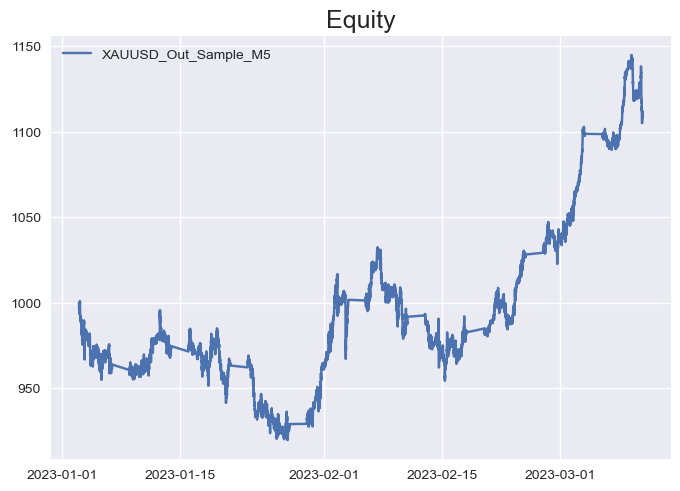

In [126]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [127]:
filename_train = f'result_{TF}_In_Sample.csv'

In [128]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [129]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [130]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [131]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [132]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [133]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17812\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [134]:
train

Start                     2022-08-16 23:19:00
End                       2023-03-10 17:58:00
Duration                    205 days 18:39:00
Exposure Time [%]                      99.999
Equity Final [$]                     1581.684
Equity Peak [$]                      1587.266
Return [%]                            58.1684
Buy & Hold Return [%]                 4.98525
Return (Ann.) [%]                   92.790035
Volatility (Ann.) [%]               39.903713
Sharpe Ratio                         2.325348
Sortino Ratio                        8.941377
Calmar Ratio                         5.876701
Max. Drawdown [%]                  -15.789477
Avg. Drawdown [%]                   -0.180815
Max. Drawdown Duration      102 days 15:05:00
Avg. Drawdown Duration        0 days 06:02:00
# Trades                                63026
Win Rate [%]                         65.14137
Best Trade [%]                        1.29732
Worst Trade [%]                     -1.515421
Avg. Trade [%]                    

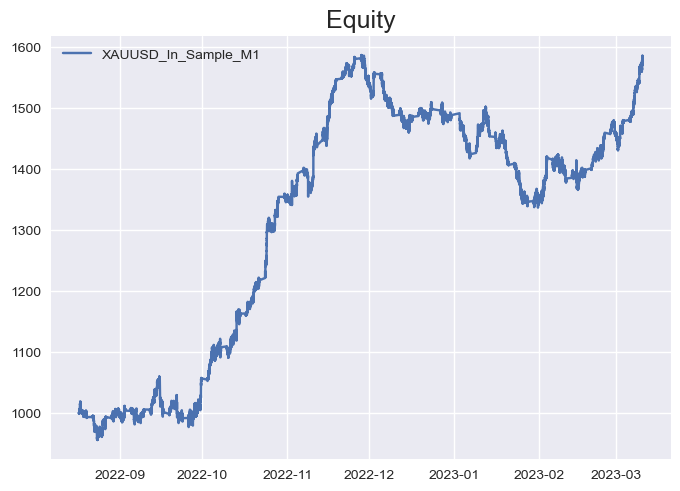

In [135]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [136]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1092.649
Equity Peak [$]                      1097.674
Return [%]                             9.2649
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                   49.388176
Volatility (Ann.) [%]               42.722892
Sharpe Ratio                         1.156012
Sortino Ratio                         2.93511
Calmar Ratio                         3.023674
Max. Drawdown [%]                  -16.333832
Avg. Drawdown [%]                   -0.246282
Max. Drawdown Duration       53 days 22:48:00
Avg. Drawdown Duration        0 days 08:51:00
# Trades                                21030
Win Rate [%]                        65.349501
Best Trade [%]                       0.891826
Worst Trade [%]                     -1.176474
Avg. Trade [%]                    

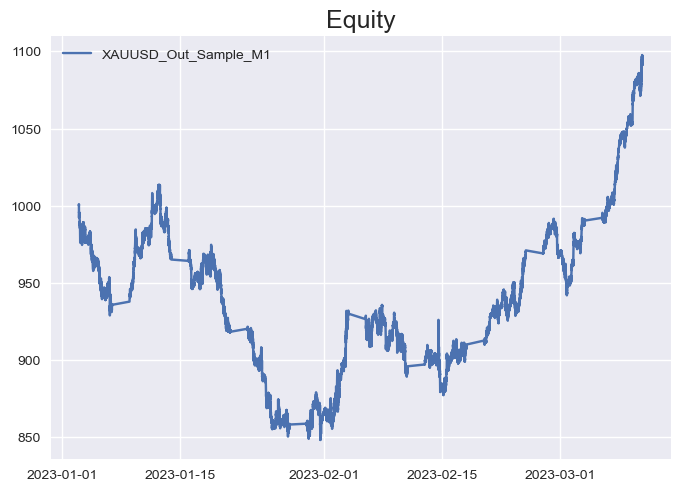

In [137]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [138]:
filename_train = f'result_{TF}_In_Sample.csv'

In [139]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')